In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('data.csv')
df.sort_values(by = ['title'], inplace = True)
df.head()

,Unnamed: 0,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,lenotz
91004,91004,г,False,а,6,лицензия № 1326,AceVentura,альфа банк,2013-02-11 16:28:00,добрый день интересует вопрос по поводу начисл...,NaN,132
66137,66137,г санкт петербург,False,а арсен гасанович то не знает,1,лицензия № 1481,vvalera,сбербанк россии,2013-11-29 13:54:00,получил сообщения не принадлежащие мне уважаем...,NaN,60
86407,86407,г москва,False,а ацтеки были правы,0,лицензия № 3311,dmitry_m@,кредит европа банк,2013-04-09 15:40:00,зря я не верил в предсказание ацтеков о конце ...,1.0,132
151584,151584,NaN,False,а банк вообще существует,2,лицензия № 2763,Дмитрий,инвестторгбанк,2005-11-11 01:33:00,решил открыть вклад в этом банке посмотрел адр...,1.0,84
90966,90966,г москва,False,а банк ли это был,3,лицензия № 2410,Alex321,промышленно финансовое сотрудничество,2013-02-11 15:34:00,пфс на меня произвел неизгладимо гадкое впечат...,NaN,273


In [3]:
df.title.value_counts()

претензия                                                                             399
кредитная карта                                                                       357
жалоба                                                                                310
благодарность                                                                         287
банкомат съел деньги                                                                  271
                                                                                     ... 
угрозы о перепродаже долга вместо ответа на заявление об опротестовании транзакций      1
оплата через терминалы                                                                  1
банк который не дорожит своими клиентами                                                1
день списания средств заявление                                                         1
частично досрочное погашение в лето банке                                               1
Name: titl

In [4]:
pop = df.groupby('title').count().sort_values(by = ['text']).reset_index()
pop = pop[pop['text'] >= 10]

In [5]:
pop['title']

116040               доверяй но проверяй
116041    мошенники сняли деньги с карты
116042                   просто нет слов
116043                        жду ответа
116044              приятное впечатление
                       ...              
116749              банкомат съел деньги
116750                     благодарность
116751                            жалоба
116752                   кредитная карта
116753                         претензия
Name: title, Length: 714, dtype: object

In [6]:
# ограничиваем количество срок самыми популярными отзывами чтобы лемматизация шла быстрее 

data = df.loc[df['title'].isin(pop['title'])][['title', 'text']]
data.head()

,title,text
62456,а в ответ тишина,открывала вклад доброе дело и карту автокопилк...
141832,а в ответ тишина,плохая работа клиентской поддержки а может быт...
38149,а в ответ тишина,здравствуйте был сегодня в отделении смп банка...
117212,а в ответ тишина,сегодня в утра раздается звонок я еще толком н...
124532,а в ответ тишина,предыстория добрый день юлия написал заявление...


### Препроцессинг

In [7]:
import re
from nltk.corpus import stopwords

In [8]:
from pymystem3 import Mystem
m = Mystem()

In [11]:
mystopwords = stopwords.words('russian') + [
    'это', 'наш' , 'тыс', 'млн', 'млрд', 'также',  'т', 'д',
    'который','прошлый','сей', 'свой', 'наш', 'мочь', 'такой'
]
ru_words = re.compile("[А-Яа-я]+")


def words_only(text):
    return " ".join(ru_words.findall(text))


def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return "" 


def remove_stopwords(text, mystopwords = mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

    
def preprocess(text):
    return remove_stopwords(lemmatize(words_only(text.lower())))i

In [14]:
%%time
from tqdm import tqdm
tqdm.pandas(desc="progress")
data['lemtext'] = data.text.progress_apply(preprocess)

progress: 100%|████████████████████████████████████████████████████████████████| 20118/20118 [6:21:21<00:00,  1.14s/it]

Wall time: 6h 21min 21s


In [21]:
data.lemtext = data.lemtext.apply(str)

In [22]:
data.to_csv('data_lem.csv')

In [17]:
pip install gensim

## Генсим

### TfidfModel

In [18]:
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim import similarities

In [25]:
texts = [text.split() for text in data.lemtext]
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [28]:
# поизучаем, что здесь происходит
# corpus

Косинусная близость:


$$similarity=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|\|\mathbf {B} \|}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}}$$

Вычисление сходства по косинусной мере на векторах $tf-idf$:

In [29]:
tfidf = TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [12]:
corpus_tfidf

In [30]:
# %%time
index = similarities.MatrixSimilarity(corpus_tfidf)
sims = index[corpus_tfidf]

In [31]:
len(corpus)

20118

In [32]:
sims[0]

array([0.9999999 , 0.02769765, 0.04269613, ..., 0.0065799 , 0.03847967,
       0.00889753], dtype=float32)

In [33]:
sims.shape

(20118, 20118)

In [34]:
import seaborn as sns

In [36]:
# отрисовать такую матрицу не хватает оперативки

# plt.figure(figsize = (10,10))
# sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
# plt.title("Матрица близости")
# plt.show()

### Латентно-семантический анализ (LSA, LSI)


Сингулярное разложение: $M'_k = U \Sigma_k V^t_k$

* $M$ – матрица слово-документ
* $U$ – матрица документ-тема
* $k$ – число тем
* $V$ - матрица слово-тема

In [37]:
from gensim.models import lsimodel

In [38]:
%%time
lsi = lsimodel.LsiModel(corpus=corpus_tfidf, id2word=dictionary, num_topics=30)

Wall time: 10.6 s


In [39]:
lsi.show_topics(5)

[(0,
  '0.197*"карта" + 0.137*"кредит" + 0.131*"деньги" + 0.116*"банкомат" + 0.114*"заявление" + 0.102*"счет" + 0.101*"сумма" + 0.101*"отделение" + 0.093*"сказать" + 0.093*"сотрудник"'),
 (1,
  '0.334*"банкомат" + -0.243*"кредит" + 0.236*"карта" + 0.209*"деньги" + -0.205*"звонок" + -0.173*"ваш" + -0.155*"номер" + -0.147*"страховка" + 0.144*"сбербанк" + 0.126*"операция"'),
 (2,
  '0.458*"вклад" + -0.214*"банкомат" + -0.186*"номер" + 0.158*"открывать" + 0.146*"очередь" + -0.128*"звонок" + -0.115*"заявление" + 0.111*"офис" + -0.107*"деньги" + -0.100*"поступать"'),
 (3,
  '-0.351*"страховка" + -0.242*"кредит" + 0.230*"номер" + 0.199*"звонок" + 0.197*"вклад" + -0.191*"сумма" + -0.164*"погашение" + -0.157*"страхование" + -0.151*"платеж" + -0.146*"руб"'),
 (4,
  '0.403*"карта" + -0.378*"вклад" + -0.308*"банкомат" + 0.231*"заявка" + -0.139*"деньги" + 0.128*"кредитный" + 0.120*"лимит" + 0.118*"заблокировать" + -0.114*"купюра" + 0.112*"перевыпуск"')]

Как снижение размерности влияет на матрицу близости:

In [41]:
# corpus_lsi = lsi[corpus]
# index = similarities.MatrixSimilarity(lsi[corpus])
# sims = index[corpus_lsi]
# sims  = (sims + 1)/2.
# plt.figure(figsize = (10,10))
# sns.heatmap(data=sims, cmap = 'Spectral').set(xticklabels=[], yticklabels=[])
# plt.title("Матрица близости")
# plt.show()

### Главные компоненты

In [43]:
X = [0] * len(data)
Y = [0] * len(data)
for i in range(len(data)):
    vec = corpus[i]
    LSI_topics = (lsi[vec])
    for topic in LSI_topics:
        if topic[0] == 0:
            X[i] = topic[1]
        elif topic[0] == 1:
            Y[i] = topic[1]

vis_df = pd.DataFrame({'X': X, 'Y': Y, 'topic' : data.title})

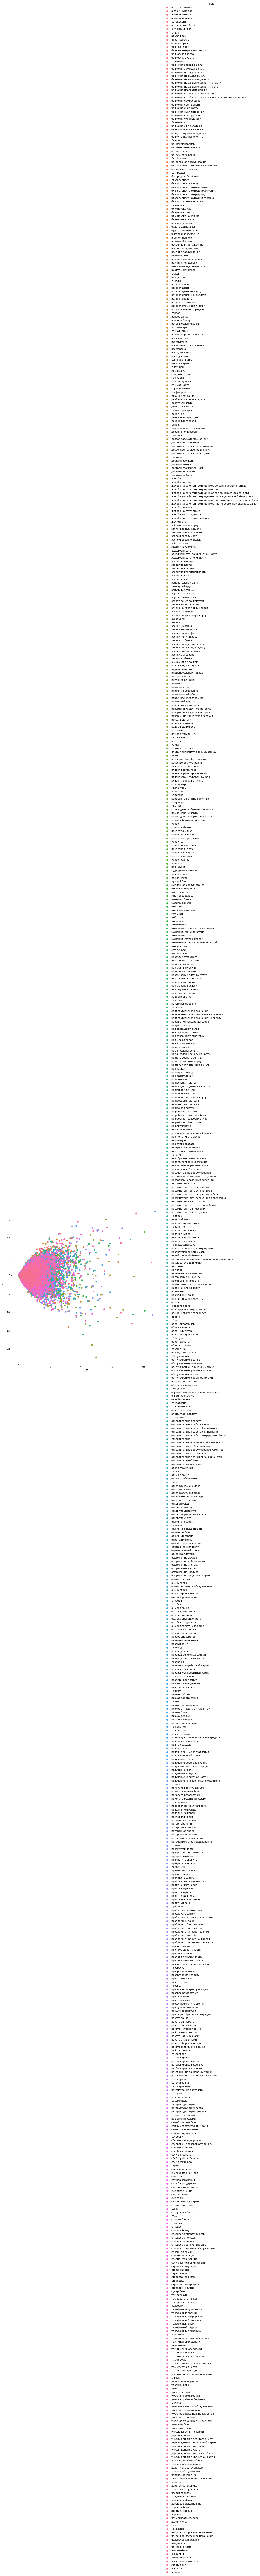

In [44]:
sns.FacetGrid(vis_df, hue="topic", size = 10).map(plt.scatter, "X", "Y").add_legend()

### Truncated SVD и TSNE

#### t-SNE
t-SNE (t-distributed Stochastic Neighbor Embedding) — техника нелинейного снижения размерности и визуализации многомерных переменных. Она разработана специально для данных высокой размерности Л. ван дер Маатеном и Д. Хинтоном. t-SNE — это итеративный алгоритм, основанный на вычислении попарных расстояний между всеми объектами (в том числе поэтому он довольно медленный).

![TSNE](TSNE.jpg)

In [45]:
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [47]:
vectors = TfidfVectorizer().fit_transform(data.lemtext) # строим тф-идф матрицу документ-слово
X_reduced = TruncatedSVD(n_components=5, random_state=0).fit_transform(vectors) # оставляем n главных компонент

In [48]:
X_reduced

array([[ 0.1567981 ,  0.03398176,  0.25844592, -0.10544755, -0.16177563],
       [ 0.21055615,  0.06626124, -0.04664251,  0.11639701, -0.11234911],
       [ 0.17189079,  0.01235176,  0.10290091, -0.03020246, -0.07755223],
       ...,
       [ 0.25757647,  0.06432604,  0.01358287, -0.11987647,  0.12564666],
       [ 0.22817812,  0.05016498,  0.0637286 , -0.04897543, -0.03084207],
       [ 0.18826785, -0.05956916,  0.0445744 ,  0.08560082,  0.04079042]])

In [49]:
# %%time
X_embedded = TSNE(n_components=2, perplexity=5, verbose=0).fit_transform(X_reduced) # строим мэппинг в двухмерную плоскость с TSNE

In [51]:
data.head()

,title,text,lemtext
62456,а в ответ тишина,открывала вклад доброе дело и карту автокопилк...,открывать вклад добрый дело карта автокопилка ...
141832,а в ответ тишина,плохая работа клиентской поддержки а может быт...,плохой работа клиентский поддержка банк ждать ...
38149,а в ответ тишина,здравствуйте был сегодня в отделении смп банка...,здравствовать сегодня отделение смп банк профс...
117212,а в ответ тишина,сегодня в утра раздается звонок я еще толком н...,сегодня утро раздаваться звонок толком просыпа...
124532,а в ответ тишина,предыстория добрый день юлия написал заявление...,предыстория добрый день юлия написать заявлени...


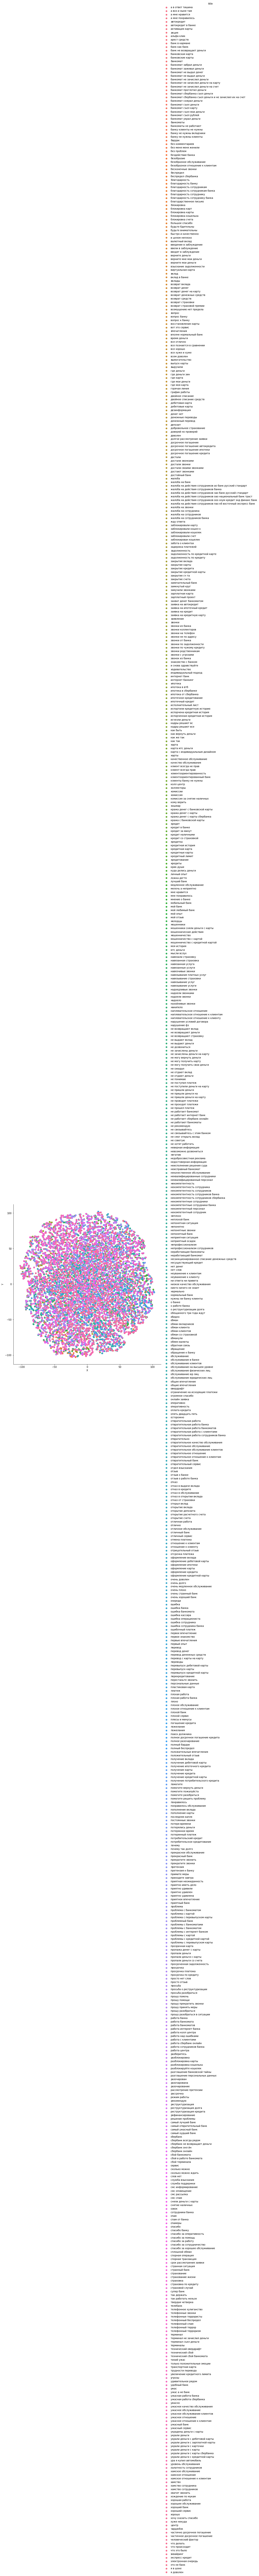

In [53]:
vis_df = pd.DataFrame({'X': X_embedded[:, 0], 'Y': X_embedded[:, 1], 'title' : data.title})
sns.FacetGrid(vis_df, hue="title", size=10).map(plt.scatter, "X", "Y").add_legend()

Advanced: [bigARTM](https://bigartm.readthedocs.io/en/stable/tutorials/python_tutorial.html)

### Задание: классификация

#### Данные

Скачиваются по [ссылке](https://drive.google.com/open?id=1gJEpwM3zdV5xe9nRU0VwQmGTiOTQdp10). Это отзывы пользователей на фильмы с КиноПоиска.

In [30]:
import pandas as pd

In [31]:
df = pd.read_csv('reviews.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'reviews.csv'

In [ ]:
df.head()

#### Задание

С помощью TruncatedSVD постройте векторное представление текстов в датасете.
Обучите на этих представлениях любой классификатор. Попробуйте разное количество компонент в интерванле от 30 до 300. Какое страдотало лучше?